# Subreddit Classification with Natural Language Processing

## Exploratory Data Analysis

*Author: Grace Campbell*

#### Project Directory
1. Data Preparation 
    - [Data Gathering](http://localhost:8889/notebooks/projects/project_3/data-gathering.ipynb)
    - *Exploratory Data Analysis*
2. Modeling
    - [Naive Bayes](http://localhost:8889/notebooks/projects/project_3/modeling-naive-bayes.ipynb)
    - [$k$-Nearest Neighbors](http://localhost:8889/notebooks/projects/project_3/modeling-knn.ipynb)
    - [Support-Vector Machine](http://localhost:8889/notebooks/projects/project_3/modeling-svm.ipynb)

In [2]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

df = pd.read_csv('./materials/titles.csv')

Let's take a preliminary look at the titles and classes in the data.

In [85]:
# Looking at a few of the titles from each subreddit -- /r/TheOnion = 1, /r/News = 0
pd.options.display.max_colwidth = 300
df[:5].append(df[-11:-6])

,title,is_onion
0,Trump threatens to close U.S.-Mexico border next week,0
1,German Government Refuses to Recognise Guaido’s Envoy as Ambassador,0
2,Netanyahu Takes Shot At Obama In Campaign Ad,0
3,MPs asked to vote on withdrawal agreement only,0
4,The shock of the nude: Brazil's stark new form of political protest,0
1572,Report: It Pretty Incredible That Americans Entrusted With Driving Cars,1
1573,Self-Conscious Puppet Has No Idea What To Do With Hands,1
1574,5 Tokyo Buildings Godzilla Spared Because He Was Considering Having His Bar Mitzvah There,1
1575,Nation’s Flag Nerds Anxiously Watching D.C. Statehood Push,1
1576,"‘This One Means The Least Of All,’ Says Tom Brady Accepting Super Bowl Trophy",1


In [86]:
# Are there any null values?
df.isnull().sum()

title       0
is_onion    0
dtype: int64

In [87]:
# Are classes balanced?
df['is_onion'].value_counts(normalize=True)

1    0.599495
0    0.400505
Name: is_onion, dtype: float64

There are no null values in this dataset. The classes are relatively balanced, with ~60% of the data from /r/TheOnion and ~40% from /r/News.

### Preprocessing the Data

First, I need to process the titles into tokens and vectorize them so that I can perform exploratory analysis and begin modeling.

This will take two steps:
1. Create a tokenizing function to break down each title into tokens.
    - Convert each word to a token that only includes alphabetical elements (i.e. no numbers or special characters)
    - Remove English stop words from the tokens list.
    - Define a function that transforms Penn Treebank part-of-speech tags into WordNet part-of-speech tags.
    - Use that function to map each token to its lemma.
    - Return the final list of lemmatized tokens.
    
    
    
2. Use CountVectorizer to transform every word into a count of its frequency across documents.
    - For now, do not specify any parameters in the CountVectorizer except the tokenizing function.

In [88]:
# To convert TreeBank POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# To return a list of lemmatized tokens
def token_func(document):
    tokenizer = RegexpTokenizer('[a-zA-Z]+')
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(document.lower())
    words = [w for w in tokens if w not in stopwords.words('english')]
    tagged = pos_tag(words)
    lemmas = []
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            lemma = lemmatizer.lemmatize(word)
            lemmas.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
            lemmas.append(lemma)
    return lemmas

# I saved this block of code into the file 'tokenizer.py' so I can call it in later notebooks.

In [91]:
cvec = CountVectorizer(tokenizer=token_func)

features = cvec.fit_transform(df['title'])

In [92]:
features_df = pd.DataFrame(features.todense(), columns=cvec.get_feature_names()).join(df['is_onion'])

In [93]:
# How many unique words do we have in this entire dataset?
len(cvec.get_feature_names())

5055

In [94]:
features_df = features_df.rename(columns={'u': 'u.s.'})

In [188]:
# In the titles from /r/TheOnion, what are the 10 most frequently seen words? 
features_df[features_df['is_onion'] == 1].sum().sort_values(ascending=False)[1:11]

new       74
man       66
say       60
get       53
trump     42
report    39
year      38
woman     37
time      34
make      33
dtype: int64

In [191]:
# In the titles from /r/News, what are the 10 most frequently seen words? 
features_df[features_df['is_onion'] == 0].sum().sort_values(ascending=False).head(10)

u.s.      85
say       75
brexit    58
trump     46
may       43
year      41
deal      34
new       32
report    32
eu        31
dtype: int64

In this first look, it appears that 'new' appears most frequently in titles from /r/TheOnion, while 'u.s.' appears the most in titles from /r/News. It looks like the words 'trump', 'report', and 'year' will not be very discerning, as both groups of titles see these words appear frequently.

In [97]:
# How many words only appear once in /r/TheOnion titles?
(features_df.loc[features_df['is_onion'] == 1, :].sum() == 1).sum()

2357

In [98]:
# How many words only appear once in /r/News titles?
(features_df.loc[features_df['is_onion'] == 0, :].sum() == 1).sum()

1416

In [99]:
# How many words only appear once in the entire dataset?
(features_df.sum() == 1).sum()

2906

It appears that titles from /r/TheOnion contain more words that are unique within that subset of titles: there are 2,357 words that only appear once in the /r/TheOnion titles. By contrast, the /r/News titles have 1,416 such words.

Out of the 5,055 unique words in the entire dataset, only 2,419 appear more than once.

Let's look at the most common words that are unique to each subreddit:

In [186]:
# Creating the list of words that show up more than 10 times, for each subreddit
onion_words = list(features_df.loc[:, features_df.loc[features_df['is_onion'] == 1, :].sum() > 0].sum().index[:-1])
news_words = list(features_df.loc[:, features_df.loc[features_df['is_onion'] == 0, :].sum() > 0].sum().index)

# Iterating through the lists to create a Series of words unique to each subreddit + the word count
onion_unique = [word for word in onion_words if word not in news_words]
news_unique = [word for word in news_words if word not in onion_words]

onion_unique_df = (features_df[onion_unique].sum().sort_values(ascending=False)[:16])
news_unique_df  = (features_df[news_unique].sum().sort_values(ascending=False)[:16])

# Creating dataframe 
pd.DataFrame({
    'onion_word': onion_unique_df.index,
    'onion_count': onion_unique_df.values,
    'news_word': news_unique_df.index,
    'news_count': news_unique_df.values
})

,onion_word,onion_count,news_word,news_count
0,watch,21,eu,31
1,good,18,uk,24
2,fuck,16,climate,21
3,mom,14,theresa,19
4,everyone,12,parliament,18
5,beautiful,12,china,16
6,god,12,trade,15
7,fan,11,mexico,13
8,night,11,boeing,13
9,bowl,10,april,11


### Visualization

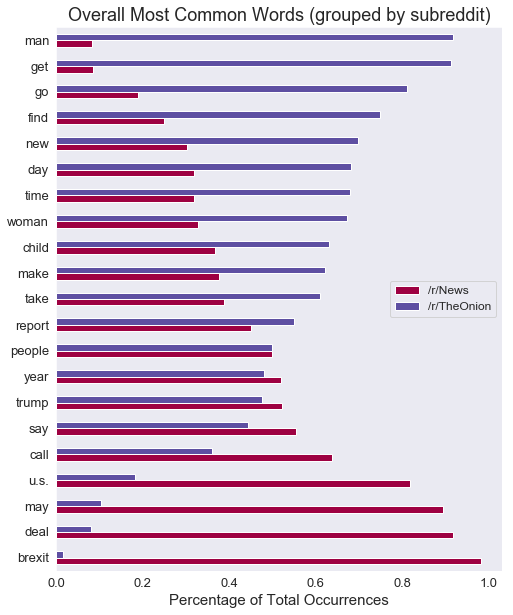

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

# Making a list of the most common words in the entire dataset and turning it into a dataframe
most_common = list(features_df.sum().sort_values(ascending=False).index[1:22])
common_df = features_df[most_common].groupby(features_df['is_onion']).sum().T

# Creating new columns in order to configure the visualization
common_df['total'] = (common_df[1]+common_df[0])
common_df['onion_%'] = common_df[1]/common_df['total']
common_df['news_%'] = common_df[0]/common_df['total']
common_df = common_df.sort_values(by='onion_%')

# Plotting/formatting
ax = common_df[['news_%', 'onion_%']].plot(kind='barh', figsize=(8, 10), fontsize=13, colormap='Spectral')
ax.set_title('Overall Most Common Words (grouped by subreddit)', fontsize=18)
ax.legend(labels=['/r/News', '/r/TheOnion'], loc=7, fontsize='large')
ax.set_xlabel('Percentage of Total Occurrences', fontsize=15);

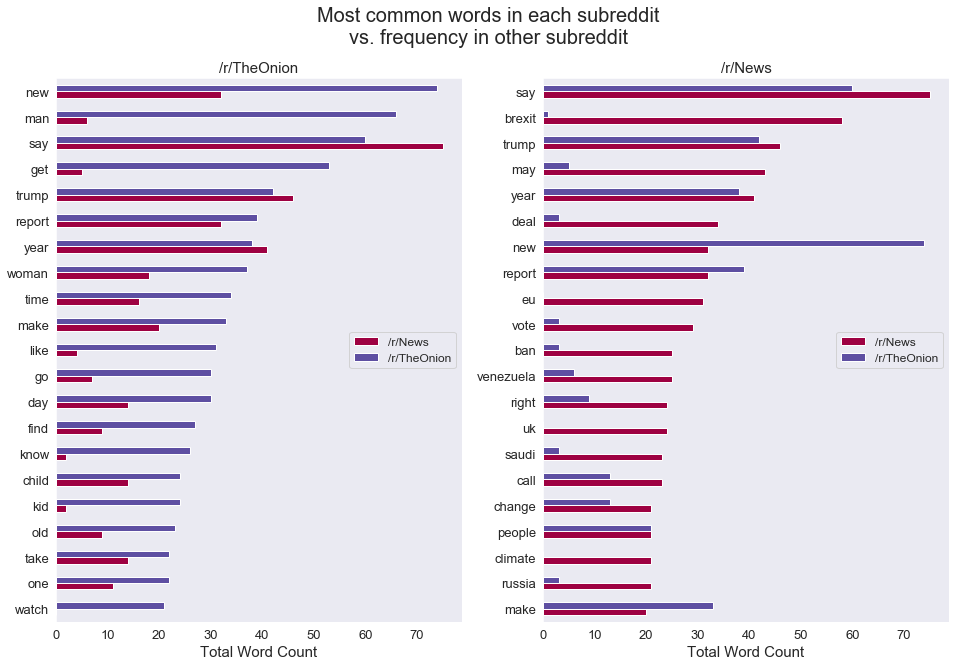

In [163]:
# Making a list of the 21 most common words in each subreddit
onion_common = list(features_df.loc[features_df['is_onion'] == 1, :].sum().sort_values(ascending=False).index[1:22])
news_common = list(features_df.loc[features_df['is_onion'] == 0, :].sum().sort_values(ascending=False).index[1:22])

# Turning those lists into dataframes to plot
onion_common_df = features_df[onion_common].groupby(features_df['is_onion']).sum().T.sort_values(by=1)
news_common_df = features_df[news_common].groupby(features_df['is_onion']).sum().T.sort_values(by=0)

# Plotting/formatting
plt.figure().suptitle('Most common words in each subreddit\nvs. frequency in other subreddit', fontsize=20)

ax1 = plt.subplot(121)
onion_common_df.plot(kind='barh', figsize=(16, 10), fontsize=13, colormap='Spectral', ax=ax1)
ax1.set_title('/r/TheOnion', fontsize=15)
ax1.legend(labels=['/r/News', '/r/TheOnion'], loc=7, fontsize='large')
ax1.set_xlabel('Total Word Count', fontsize=15);

ax2 = plt.subplot(122)
news_common_df.plot(kind='barh', fontsize=13, colormap='Spectral', ax=ax2)
ax2.set_title('/r/News', fontsize=15)
ax2.legend(labels=['/r/News', '/r/TheOnion'], loc=7, fontsize='large')
ax2.set_xlabel('Total Word Count', fontsize=15);